In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. You should probably not do this.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

0:year,1:Start_date,2:ProfitLoss,3:GrossResult,4:Assets,5:AverageNumberOfEmployees,6:Equity,7:AddressOfReportingEntityPostCodeIdentifier

In [4]:
years = 6
data = np.load('data_train_{}.npy'.format(years),allow_pickle=True)
target = np.load('data_target_{}.npy'.format(years),allow_pickle=True)

In [5]:
#Changes address to first number in postcode or 0 if there isn't one
data = data[:,:,2:] 
target = target[:,2:]
'''
0:ProfitLoss,1:GrossResult,2:Assets,3:AverageNumberOfEmployees,4:Equity,5:AddressOfReportingEntityPostCodeIdentifier
'''
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,5] = int(str(data[i,j,5])[0])
        except:
            data[i,j,5] = 0
for i in range(target.shape[0]):
    try:
        target[i,5] = int(str(target[i,5])[0])
    except:
        target[i,5] = 0

In [6]:
#remove remaining strings
index_of_string = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            try:
                float(data[i,j,k])
            except:
                index_of_string.append((i))
                
index_of_string = np.array(index_of_string)
index_of_string = np.unique(index_of_string)                
data = np.delete(data,index_of_string,axis=0)
target = np.delete(target,index_of_string,axis=0)

C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]
C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [7]:
#remove nan
nan_ = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            if np.isnan(data[i,j,k]):
                nan_.append(i)
nan_ = np.array(nan_)
nan_ = np.unique(nan_)
data = np.delete(data,nan_,axis=0)
target = np.delete(target,nan_,axis=0)

C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Bruger\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#removes any entry with a zero in profitloss, GrossResult, assets or equity
has_zero = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i,j,0] == 0 or data[i,j,1] == 0 or data[i,j,2] == 0 or data[i,j,4] == 0:
            has_zero.append(i)
has_zero = np.unique(np.array(has_zero))
data = np.delete(data,has_zero,axis=0)
target = np.delete(target,has_zero,axis=0)

In [9]:
data[data[:,:,2] < 10000000].shape

(26135, 6)

In [10]:
big_company_pos = []
medium_company_pos = []
small_company_pos = []
big_company_neg = []
medium_company_neg = []
small_company_neg = []

for i in range(data.shape[0]):
    if np.median(data[i,:,1]) < 0:
        if np.mean(data[i,:,2]) < 100000:
            small_company_neg.append(i)
        elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
            medium_company_neg.append(i)
        else:
            big_company_neg.append(i)
    else:
        if np.mean(data[i,:,2]) < 100000:
            small_company_pos.append(i)
        elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
            medium_company_pos.append(i)
        else:
            big_company_pos.append(i)
    
#     if max(abs(data[i,:,2])) < 100000:
#         small_company.append(i)
#     elif max(abs(data[i,:,2])) > 100000 and data[i,:,2].mean() < 10000000:
#         medium_company.append(i)
#     else:
#         big_company.append(i)

In [11]:
len(small_company_neg)

86

In [12]:
len(small_company_pos)

19

In [13]:
len(medium_company_neg)

1666

In [14]:
len(medium_company_pos)

2568

In [15]:
len(big_company_neg)

516

In [16]:
len(big_company_pos)

878

In [17]:
data = data.astype("float")
target = target.astype("float")

In [18]:
data = data[medium_company_pos]
target = target[medium_company_pos]
# data_small = data[small_company]
# target_small = target[small_company]
# data_medium = data[medium_company]
# target_medium = target[medium_company]

In [19]:
data = data[:,:,0:3]

In [20]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

#target index
target_index = 1

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,:]
train_target = target[train_idx,target_index] 
test_data = data[test_idx,:,:]
test_target = target[test_idx,target_index]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [21]:
# #for data_grouped.npy
# zeros_ = np.zeros(6)
# for i in range(6):
#     temp = data[:,:,i].clone()
#     zeros_[i] = temp[temp==0].shape[0]
    
# pct_zeros = zeros_/(data.shape[0]*3)
# print('0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier')
# print(pct_zeros)

In [22]:
batch_size=100

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

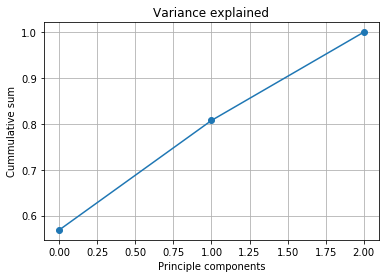

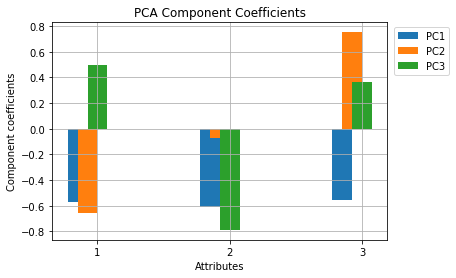

In [23]:
temp = data.clone()
temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
temp = temp.numpy()

# #standardize data 
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))
#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(3)
for i in range(3):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
# plt.savefig("variance_explained")
plt.show()

M=3
pcs = np.arange(3)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/2, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

In [24]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [25]:
class RecurrentNetSkip(nn.Module):
    def __init__(self,years):
        super(RecurrentNetSkip, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=3,
                          hidden_size=50,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=(50+3)*years,out_features=50),
                                       nn.BatchNorm1d(50),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,6]
        
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         z = torch.cat(temp,dim=1) #[batch_size,3,6]
        
#         y = torch.cat((z,x),dim=2) #[batch_size,3,12]
                                            
        y,_ = self.rnn(x) #[batch_size,years,50]
        
        x = torch.cat((x,y),dim=2) #[batch_size,years,50+3]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,(50+3)*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [26]:
class RecurrentNet(nn.Module):
    def __init__(self,years):
        super(RecurrentNet, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=3,
                          hidden_size=50,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=50*years,out_features=50),
                                       nn.BatchNorm1d(50),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,3]
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         x = torch.cat(temp,dim=1) #[batch_size,3,6]
                                            
        x,_ = self.rnn(x) #[batch_size,years,50]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,50*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [27]:
class LinearNet(nn.Module):
    def __init__(self,years):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=years*3,out_features=16),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(16,32),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(32,64),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(64,128),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(128,256),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(256,128),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(128,64),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(64,32),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(32,16),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.75),
                                      nn.Linear(16,1))

        
    def forward(self, x): #x = [batch_size,3,3]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [28]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
        
#         self.conv = nn.Sequential(nn.BatchNorm1d(10),
#                                   nn.Conv1d(in_channels=10,out_channels=20,kernel_size=3,padding=1),
#                                   nn.ReLU(),
#                                   nn.BatchNorm1d(20),
#                                   nn.Conv1d(20,40,kernel_size=3,padding=1),
#                                   nn.ReLU(),
#                                   nn.BatchNorm1d(40),
#                                   nn.Conv1d(40,80,kernel_size=3,padding=1),
#                                   nn.ReLU(),
#                                   nn.BatchNorm1d(80),
#                                   nn.Conv1d(80,160,kernel_size=3,padding=1),
#                                   nn.ReLU(),
#                                   nn.Conv1d(160,320,kernel_size=3,padding=0))
        
#         self.linear = nn.Sequential(nn.Linear(in_features=320,out_features=160),
#                                     nn.ReLU(),
#                                     nn.Dropout(),
#                                     nn.Linear(160,80),
#                                     nn.ReLU(),
#                                     nn.Dropout(),
#                                     nn.Linear(80,40),
#                                     nn.ReLU(),
#                                     nn.Dropout(),
#                                     nn.Linear(40,20),
#                                     nn.ReLU(),
#                                     nn.Dropout(),
#                                     nn.Linear(20,1))
                                  
        
#     def forward(self, x): #x = [batch_size,features,3]
#         x = self.conv(x) #[batch_size,160,1]
#         x = x.view(x.shape[0],-1) #[batch_size,160]
#         x = self.linear(x) #[batch_size,1]
        
#         x = x.view(-1) #When prediction one value
#         return x

In [85]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def percent_loss(pred,target):
    count_bad_pred = 0
    temp = pred < torch.ones(pred.shape[0])*1000
    temp2 = pred > torch.ones(pred.shape[0])*-1000
    for i in range(pred.shape[0]):
        if temp[i] == temp2[i]:
            count_bad_pred += 1

    return torch.sum(torch.abs(torch.abs(pred-target)/(target+1)))+count_bad_pred*10000

In [80]:
model1 = LinearNet(years)
# model2 = RecurrentNet(years)
# model3 = RecurrentNetSkip(years)
model1.to(device)
# model2.to(device)
# model3.to(device)
lr = 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
# optimizer2 = optim.Adam(model2.parameters(), lr=lr)
# optimizer3 = optim.Adam(model3.parameters(), lr=lr)

critirion = nn.SmoothL1Loss()

In [81]:
#Training loop
num_epochs = 10
train_loss1 = []
test_loss1 = []
# train_loss2 = []
# test_loss2 = []
# train_loss3 = []
# test_loss3 = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error1 = 0
#     train_error2 = 0
#     train_error3 = 0
    model1.train()
#     model2.train()
#     model3.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer1.zero_grad()
#         optimizer2.zero_grad()
#         optimizer3.zero_grad()
        #Forward pass your image through the network
        output1 = model1(data)
#         output2 = model2(data)
#         output3 = model3(data)
        #Compute the loss
        loss1 = percent_loss(output1,target)
#         loss2 = percent_loss(output2,target)
#         loss3 = percent_loss(output3,target)
#         loss1 = critirion(output1,target)
#         loss2 = critirion(output2,target)
#         loss3 = critirion(output3,target)

        #Backward pass through the network
        loss1.backward()
#         loss2.backward()
#         loss3.backward()
        #Update the weights
        optimizer1.step()
#         optimizer2.step()
#         optimizer3.step()
        train_error1 += loss1
#         train_error2 += loss2
#         train_error3 += loss3
        
        
    #Comput the test accuracy
    model1.eval()
#     model2.eval()
#     model3.eval()
    test_error1 = 0
#     test_error2 = 0
#     test_error3 = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output1 = model1(data)
#             output2 = model2(data)
#             output3 = model3(data)
        test_error1 += percent_loss(output1,target)
#         test_error2 += percent_loss(output2,target)
#         test_error3 += percent_loss(output3,target)
#         test_error1 += critirion(output1,target)
#         test_error2 += critirion(output2,target)
#         test_error3 += critirion(output3,target)
        
    train_err1 = train_error1/len(trainset)
    train_loss1.append(train_err1)
    test_err1 = test_error1/len(testset)
    test_loss1.append(test_err1)
#     train_err2 = train_error2/len(trainset)
#     train_loss2.append(train_err2)
#     test_err2 = test_error2/len(testset)
#     test_loss2.append(test_err2)
#     train_err3 = train_error3/len(trainset)
#     train_loss3.append(train_err3)
#     test_err3 = test_error3/len(testset)
#     test_loss3.append(test_err3)
#     print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}\n train error 2: {train2:.1f}\t test error 2: {test2:.1f}\n train error 3: {train3:.1f}\t test error 3: {test3:.1f}".format(test1=test_err1, test2=test_err2, test3=test_err3, train1=train_err1, train2=train_err2, train3=train_err3))
    print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}".format(test1=test_err1,train1=train_err1))

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


KeyboardInterrupt: 

In [78]:
print(target[:10])
temp =model1(data[:10])
print(temp)

tensor([ 148127.,  493260.,  315243., 1286887., -144030., 9593368.,  153886.,
         993509., 2036022.,  403604.])
tensor([ -9.8004,  -0.4881,  -0.9780,  -1.4696,   6.7166, -13.1293,  -1.0311,
         -0.0909,  -2.0806,  -4.8451], grad_fn=<ViewBackward>)


In [ ]:
plt.plot(train_loss1)
plt.plot(test_loss1)
plt.legend(["train loss","test loss"])
plt.title("Loss for recurrent network on medium companies")
plt.xlabel("epochs")
# plt.savefig("loss_plot_mc")
plt.show()

In [87]:
#predicts the average over the last 3 years
baseline_loss = 0
for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):  
    y_pred = data[:,:,0].mean(1)
#     y_pred = data.mean(1)
    loss = critirion(y_pred,target)
#     loss = percent_loss(y_pred,target)
    baseline_loss += loss.numpy()
baseline_loss /= len(trainset)
print("baseline error: {error:.1f}".format(error =baseline_loss))

baseline error: 18742.2


In [ ]:
# torch.save(model.state_dict(),"Current_Assets")